# Task 3: Reconstruction activation map given ECG leads

Sequence-to-vector prediction of voltage recordings and ECG Signals to perform activation map reconstruction 
(i.e. transform 12x500 standard leads recordings to a 75x1 activation map using a neural network)

Download the dataset from the Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals using the script: https://library.ucsd.edu/dc/object/bb29449106

The dataset Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals. In total, 16140 organ-level simulations were conducted to create this dataset. Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores. Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals. For convenience, we collect those signals in matrices and give them the following names:

Tensor	Description	  Shape	          Notes
X 	Row electrode signals	 10×500 	10-lead ECG signals from the simulated torso (in Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals)
V 	Activation map	 75×500 	Transmembrane voltage signals from the simulated heart (in Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals)
E 	12-lead ECG signals	 12×500 	12-lead ECG signals obtained by get_standard_leads( X )
A 	Activation map	 75×1 	Activation time, defined as  Ai=minj(Vij) 
IMPORTANT : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function get_standard_leads (in the file cardiac_ml_tools.py).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

In [44]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.metrics import accuracy_score, r2_score
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os 
import random

In [2]:
# cardiac_ml_tools.py (download_intracardiac_dataset.sh)

# file containing functions for cardiac ml
import glob, re, os
from typing import List
import numpy as np

# %%
# funtion to read the data
def read_data_dirs(
        dirs_names : List[str] = ['../intracardiac_dataset/data_hearts_dd_0p2/'],
        verbose : int = 0) -> List[List[str]]:
    """
    Read the numpy files in the given directories.
    Returns a list of file pairs ECG/Vm.
    
    Parameters
    ----------
    dirs_names : List[str]
        List of directories containing the data.
    verbose : int
        Verbosity level.
    
    Returns
    -------
    file_pairs : List[List[str]]
        List of file pairs.
    """
    file_pairs = []
    
    for dir in dirs_names:    
        all_files = sorted(glob.glob(dir + '/*.npy'))
        files_Vm=[]
        files_pECG=[]
        
        if verbose > 0:
            print('Reading files...',end='')
        for file in all_files:
            if 'VmData' in file:
                files_Vm.append(file)
            if 'pECGData' in file:
                files_pECG.append(file)
        if verbose > 0:        
            print(' done.')
        
        if verbose > 0:
            print('len(files_pECG) : {}'.format(len(files_pECG)))
            print('len(files_Vm) : {}'.format(len(files_Vm)))
        
        for i in range(len(files_pECG)):  
            VmName =  files_Vm[i]
            VmName = VmName.replace('VmData', '')
            pECGName =  files_pECG[i]
            pECGName = pECGName.replace('pECGData', '')            
            if pECGName == VmName :
                file_pairs.append([files_pECG[i], files_Vm[i]])
            else:
                print('Automatic sorted not matching, looking for pairs ...',end='')
                for j in range(len(files_Vm)):
                    VmName =  files_Vm[j]
                    VmName = VmName.replace('VmData', '')
                    if pECGName == VmName :
                        file_pairs.append([files_pECG[i], files_Vm[j]])
                print('done.')       
    return file_pairs


# function to transform the data
def get_standard_leads(
        pECGnumpy : np.ndarray
    ) -> np.ndarray :
    """
    Get the standard 12-lead from the 10-lead ECG.
    
    Parameters
    ----------
    pECGnumpy : np.ndarray
        10-lead ECG.
        
    Returns
    -------
    ecg12aux : np.ndarray
        12-lead ECG.
    """
    # pECGnumpy  : RA LA LL RL V1 V2 V3 V4 V5 V6
    # ecg12aux : i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6
    ecg12aux = np.zeros((pECGnumpy.shape[0],12))
    WilsonLead = 0.33333333 * (pECGnumpy[:,0] + pECGnumpy[:,1] + pECGnumpy[:,2])
    # Lead I: LA - RA
    ecg12aux[:,0] = pECGnumpy[:,1] - pECGnumpy[:,0]
    # Lead II: LL - RA
    ecg12aux[:,1] = pECGnumpy[:,2] - pECGnumpy[:,0]
    # Lead III: LL - LA
    ecg12aux[:,2] = pECGnumpy[:,2] - pECGnumpy[:,1]
    # Lead aVR: 3/2 (RA - Vw)
    ecg12aux[:,3] = 1.5*(pECGnumpy[:,0] - WilsonLead)
    # Lead aVL: 3/2 (LA - Vw)
    ecg12aux[:,4] = 1.5*(pECGnumpy[:,1] - WilsonLead)
    # Lead aVF: 3/2 (LL - Vw)
    ecg12aux[:,5] = 1.5*(pECGnumpy[:,2] - WilsonLead)
    # Lead V1: V1 - Vw
    ecg12aux[:,6] = pECGnumpy[:,4] - WilsonLead
    # Lead V2: V2 - Vw
    ecg12aux[:,7] = pECGnumpy[:,5] - WilsonLead
    # Lead V3: V3 - Vw
    ecg12aux[:,8] = pECGnumpy[:,6] - WilsonLead
    # Lead V4: V4 - Vw
    ecg12aux[:,9] = pECGnumpy[:,7] - WilsonLead
    # Lead V5: V5 - Vw
    ecg12aux[:,10] = pECGnumpy[:,8] - WilsonLead
    # Lead V6: V6 - Vw
    ecg12aux[:,11] = pECGnumpy[:,9] - WilsonLead

    return ecg12aux

# funtion to get the activation time
def get_activation_time(
        Vm : np.ndarray
    ) -> np.ndarray :
    """
    Get the activation time from the Vm.
    
    Parameters
    ----------
    Vm : np.ndarray
        Vm.
        
    Returns
    -------
    actTime : np.ndarray
        Activation time.
    """
    actTime = []
    # check that Vm has 75 columns
    if Vm.shape[1] != 75:
        print('Error: Vm does not have 75 columns')
        return actTime
    for col in range(0,75,1):
        actTime.append(np.argmax(Vm[:,col]>0))
    actTime = np.asarray(actTime)
    actTime = np.reshape(actTime,(75,1))
    return actTime

In [3]:
# %% Reading file pairs  
data_dirs = []
regex = r'data_hearts_dd_0p2*'
#DIR='../content/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
DIR='C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh

for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))

print(len(data_dirs))

Number of file pairs: 16117
Example of file pair:
C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\VmData_hearts_dd_0p2_volunteer.v10_pattern.0.npy
17


Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


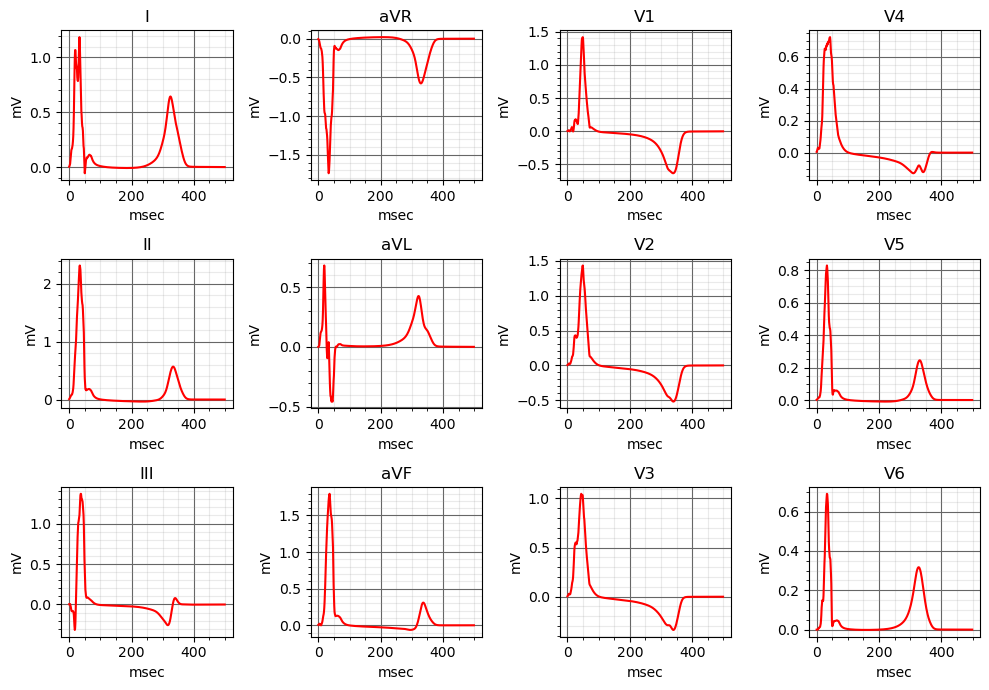

In [4]:
# %% Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r')
    plt.title(titles[i])
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()


Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


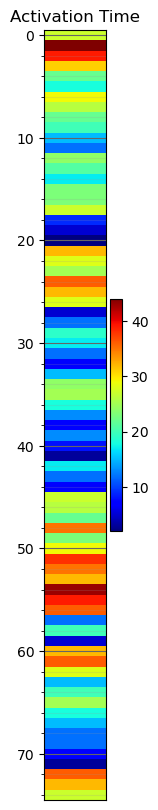

In [5]:
# %% Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()

Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy
Case 213 : C:/Users/Justin/Documents/LLNL/Data/Task3/dataset/data_hearts_dd_0p2\pECGData_hearts_dd_0p2_volunteer.v1_pattern.18.npy


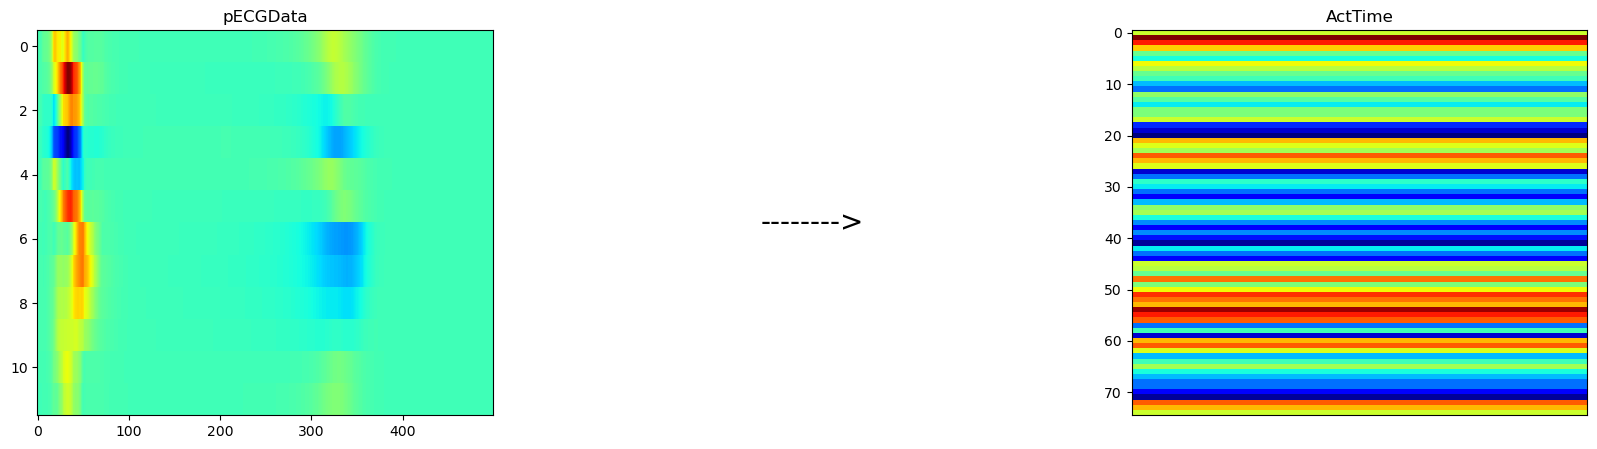

In [6]:
# %% Make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

In [7]:
# %% Load in peeps
# To choose which cases should be for testing and which should be for training
#num_of_peps = len(file_pairs)
num_of_peps = 10000

activation_times = []
standard_leads = []
for case in range(num_of_peps):

  pECGData = np.load(file_pairs[case][0])
  pECGData = get_standard_leads(pECGData)
  standard_leads.append(pECGData)

  VmData = np.load(file_pairs[case][1])
  ActTime = get_activation_time(VmData)
  activation_times.append(ActTime)

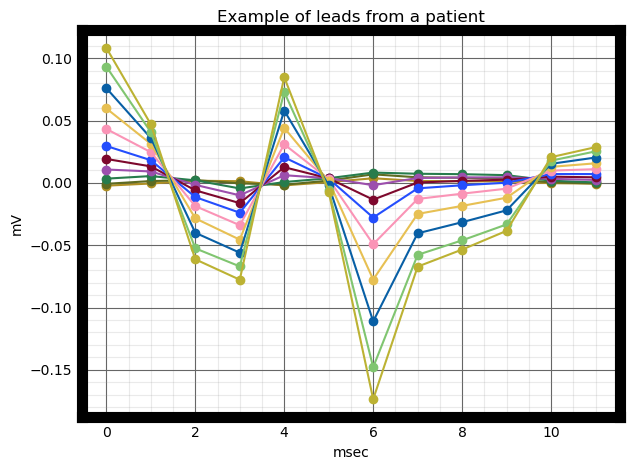

In [22]:
# %% Plotting the ecg data sets 
# Generate 12 random colors
colors = []
for _ in range(12):
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    colors.append((red / 255, green / 255, blue / 255))  # Normalize RGB values between 0 and 1

for i in range(0,11):
    plt.plot(standard_leads[case][i,0:num_timesteps], marker='o', color=colors[i])
    plt.title('Example of leads from a patient')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
    plt.tight_layout()
    
plt.show()
plt.close()


In [9]:
# %% Normalizing the data 
Y = np.array(activation_times)
X = np.array(standard_leads)

# Split the data into train and test sets
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=41)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=41)

y_train_min_vals = np.min(Y_train, axis=1, keepdims=True)
y_train_max_vals = np.max(Y_train, axis=1, keepdims=True)
y_test_min_vals = np.min(Y_test, axis=1, keepdims=True)
y_test_max_vals = np.max(Y_test, axis=1, keepdims=True)
y_valid_min_vals = np.min(Y_valid, axis=1, keepdims=True)
y_valid_max_vals = np.max(Y_valid, axis=1, keepdims=True)

Y_test_norm = (Y_test - y_test_min_vals) / (y_test_max_vals - y_test_min_vals)
Y_train_norm = (Y_train - y_train_min_vals) / (y_train_max_vals - y_train_min_vals)
Y_valid_norm = (Y_valid - y_valid_min_vals) / (y_valid_max_vals - y_valid_min_vals)

Text(0.5, 1.0, 'ECG leads')

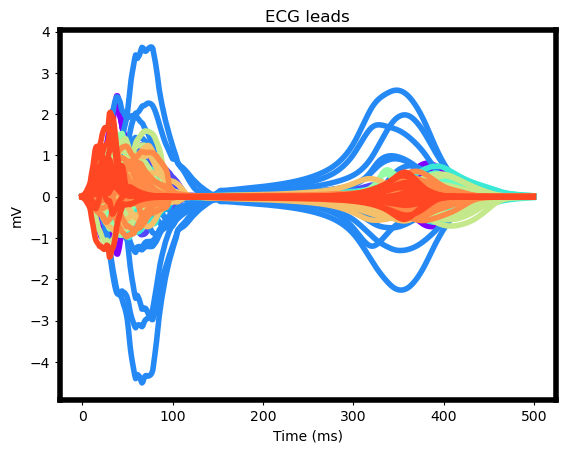

In [24]:
# Plot all example leads 
values = np.linspace(0, 1, 12)
# Get the corresponding rainbow colors
colors = plt.cm.rainbow(values)
colors = colors[:,:-1]

for i in range(0,11):
    plt.plot(X_train[i,:], color=colors[i], linewidth=4)

plt.rcParams['axes.linewidth'] = 4
plt.ylabel('mV')
plt.xlabel('Time (ms)')
plt.title('ECG leads')
#plt.xticks([])
#plt.yticks([])

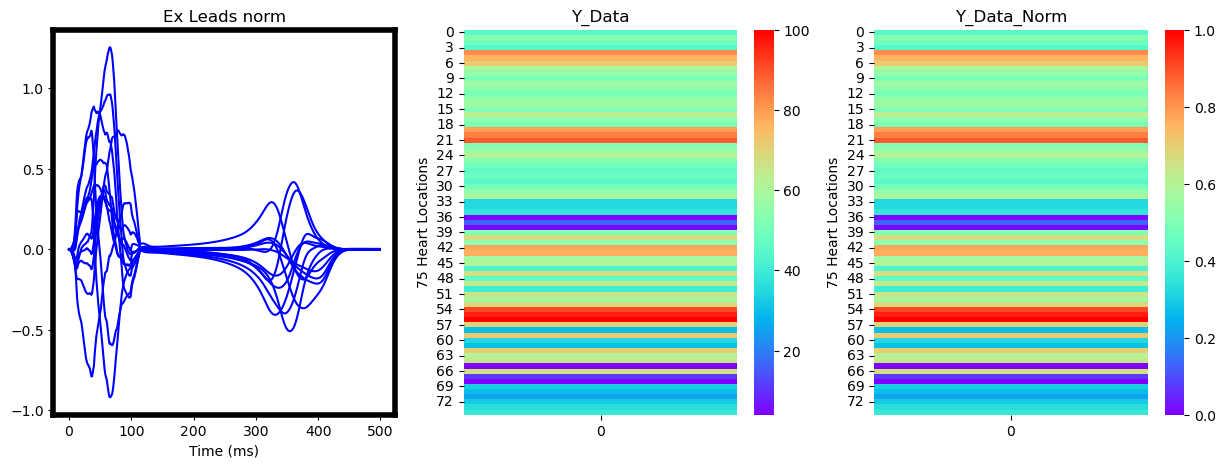

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(X_train[1,:], color='blue')
plt.xlabel('Time (ms)')
plt.title('Ex Leads norm')
plt.subplot(1,3,2)
sns.heatmap(Y_train[1,:], cmap = 'rainbow')
plt.ylabel('75 Heart Locations')
plt.title('Y_Data')
plt.subplot(1,3,3)
sns.heatmap(Y_train_norm[1,:], cmap = 'rainbow')
plt.title('Y_Data_Norm')
plt.ylabel('75 Heart Locations')

In [12]:
# 1D Convolution network using Tensorflow  
model2 = keras.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=25, input_shape=(500, 12), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=64, kernel_size=15, strides=2, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=128, kernel_size=9, strides=2, activation='relu'),
    keras.layers.BatchNormalization(), 
    keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    keras.layers.BatchNormalization(), 
    keras.layers.Flatten(),       
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.BatchNormalization(),    
    keras.layers.Dense(units=75, activation='sigmoid')])


In [13]:
# Compile model 
model2.compile(loss= 'mean_squared_error', optimizer='adam')

# Train the model
M = model2.fit(X_train, Y_train_norm, epochs=20, batch_size=32, validation_data=(X_valid, Y_valid_norm))
model2.summary()

Epoch 1/20
200/200 [==============================] - 30s 137ms/step - loss: 0.0450 - val_loss: 0.0539
Epoch 2/20
200/200 [==============================] - 20s 101ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 3/20
200/200 [==============================] - 20s 100ms/step - loss: 0.0237 - val_loss: 0.0224
Epoch 4/20
200/200 [==============================] - 19s 93ms/step - loss: 0.0220 - val_loss: 0.0431
Epoch 5/20
200/200 [==============================] - 14s 68ms/step - loss: 0.0195 - val_loss: 0.0164
Epoch 6/20
200/200 [==============================] - 15s 73ms/step - loss: 0.0142 - val_loss: 0.0120
Epoch 7/20
200/200 [==============================] - 14s 70ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 8/20
200/200 [==============================] - 13s 66ms/step - loss: 0.0111 - val_loss: 0.0083
Epoch 9/20
200/200 [==============================] - 14s 71ms/step - loss: 0.0089 - val_loss: 0.0075
Epoch 10/20
200/200 [==============================] - 17s 86ms/step - loss: 0.

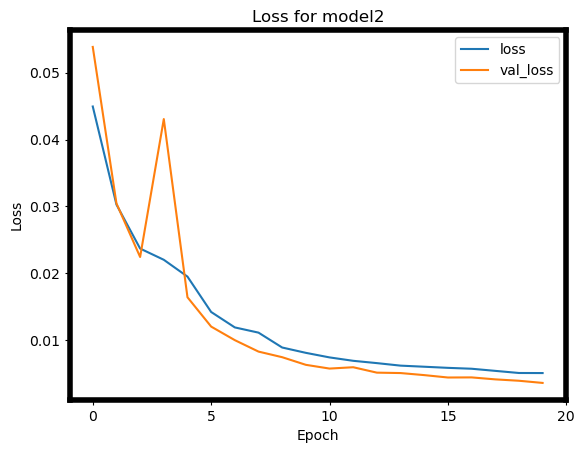

In [41]:
# Plot the loss 
loss = M.history['loss']
val_loss = M.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('Loss for model2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,25,5))
plt.show()

63/63 [==============================] - 1s 12ms/step


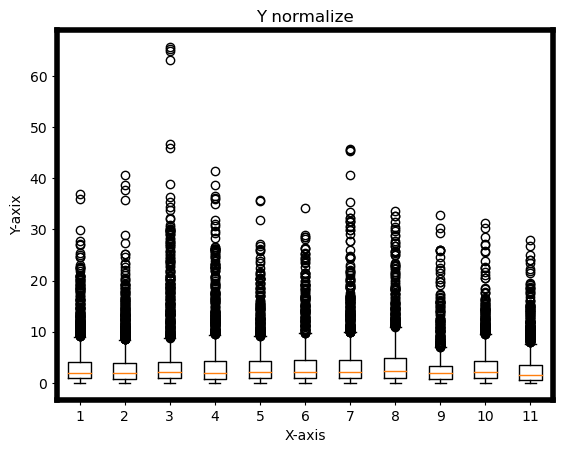

r^2 = 0.9492477055413876


In [48]:
# %% Different kinds of plotting
# Make predictions on the test data
output_pred = model2.predict(X_test)

# normalized_data * (max_vals - min_vals) + min_vals
max_vals = np.squeeze(y_test_max_vals).reshape(-1,1)
min_vals = np.squeeze(y_test_min_vals).reshape(-1,1)      
unnormalized_output_pred = output_pred * (max_vals - min_vals) + min_vals

# box plot error
error = abs(unnormalized_output_pred - np.squeeze(Y_test))
error2 = error[:,::7]

# Create a boxplot
plt.boxplot(error2) # x2
xticks = np.arange(1,16)  # Generate x-ticks from 1 to 75 by 5s
xtick_labels = np.arange(0, 70, 5)  # Generate x-tick labels from 1 to 75 by 5s
plt.xlabel('X-axis')
plt.ylabel('Y-axix')
plt.title('Y normalize')
plt.show()

r2 = r2_score(unnormalized_output_pred, np.squeeze(Y_test))
print('r^2 =', r2)

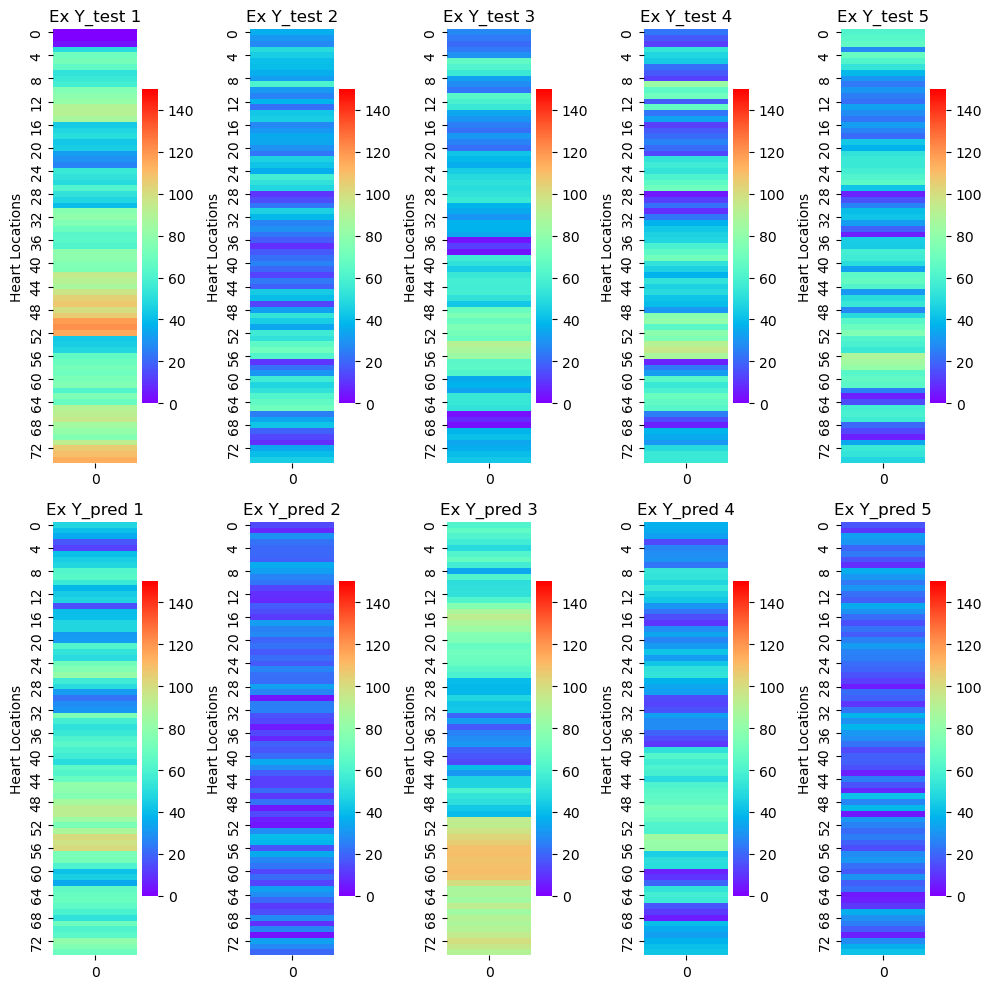

In [54]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

top_indices = np.argsort(error2,axis=0)[-5:]

# Iterate through the subplots
for i, ax in enumerate(axs):
    x = random.randint(1, 16000)
    # Plot the data on each subplot
    if i <= 4:
        sns.heatmap(Y_test[i,:].reshape(75,1), vmin=0, vmax=150, cmap = 'rainbow', ax=ax) #  vmin=0, vmax=1
        ax.set_title(f"Ex Y_test {i+1}")

    elif i > 4:
        sns.heatmap(unnormalized_output_pred[i,:].reshape(75,1), vmin=0, vmax=150, cmap = 'rainbow', ax=ax)
        ax.set_title(f"Ex Y_pred {i-4}")


    # Set x and y axis labels
    #ax.set_xlabel()
    ax.set_ylabel("Heart Locations")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

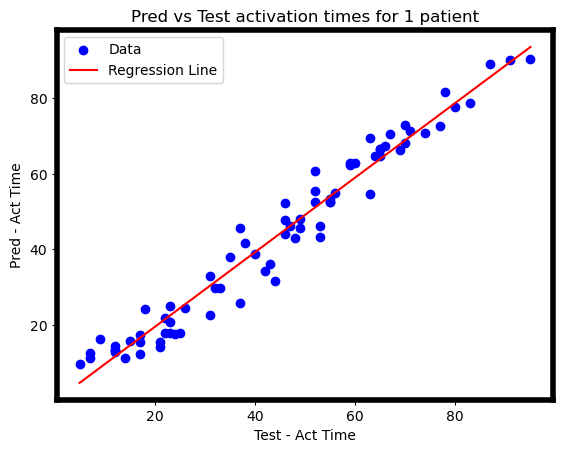

In [63]:
# %% Regression plot without confidence 
patient = 3
x = Y_test[patient,:]
y = unnormalized_output_pred[patient,:].reshape(-1,1)   

x = x.ravel() # return a contiguous flattened array 
y = y.ravel()
# Fit a regression line using numpy.polyfit
coefficients = np.polyfit(x, y, 1)  # 1 indicates linear regression

# Generate x-values for the regression line
x_line = np.linspace(min(x), max(x), 100)
y_line = np.polyval(coefficients, x_line)

# Calculate the R-squared value
y_pred = np.polyval(coefficients, x)
ss_total = np.sum((y - np.mean(y))**2)
ss_residual = np.sum((y - y_pred)**2)
r_squared = 1 - (ss_residual / ss_total)

# Plot the data points
plt.scatter(x, y, color='blue', label='Data')

# Plot the regression line
plt.plot(x_line, y_line, color='red', label='Regression Line')

# Add labels and title
plt.xlabel('Test - Act Time')
plt.ylabel('Pred - Act Time')
plt.title('Pred vs Test activation times for 1 patient')

# Add legend
plt.legend()

# Show the plot
plt.show()

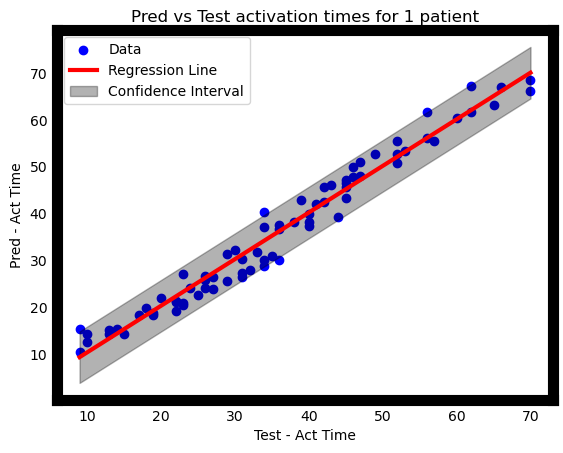

In [65]:
# %% Regression with confidence 

patient = 1
x = Y_test[patient,:]
y = unnormalized_output_pred[patient,:].reshape(-1,1)   

# Flatten the arrays to 1D
x = x.ravel()
y = y.ravel()

# Fit a regression line using numpy.polyfit
coefficients = np.polyfit(x, y, 1)  # 1 indicates linear regression

# Generate x-values for the regression line
x_line = np.linspace(min(x), max(x), 100)
y_line = np.polyval(coefficients, x_line)

# Calculate the confidence interval bounds
y_pred = np.polyval(coefficients, x)
y_error = y - y_pred
mean_error = np.mean(y_error)
std_error = np.std(y_error)
confidence = 1.96  # 95% confidence interval
lower_bound = y_line - confidence * std_error
upper_bound = y_line + confidence * std_error

# Plot the data points
plt.scatter(x, y, color='blue', label='Data')

# Plot the regression line
plt.plot(x_line, y_line, color='red', label='Regression Line', linewidth = 3)

# Plot the confidence interval
plt.fill_between(x_line, lower_bound, upper_bound, color='black', alpha=0.3, label='Confidence Interval')

# Add labels and title
# Add labels and title
plt.xlabel('Test - Act Time')
plt.ylabel('Pred - Act Time')
plt.title('Pred vs Test activation times for 1 patient')
plt.rcParams['axes.linewidth'] = 8

# Add legend
plt.legend()

# Show the plot
plt.show()

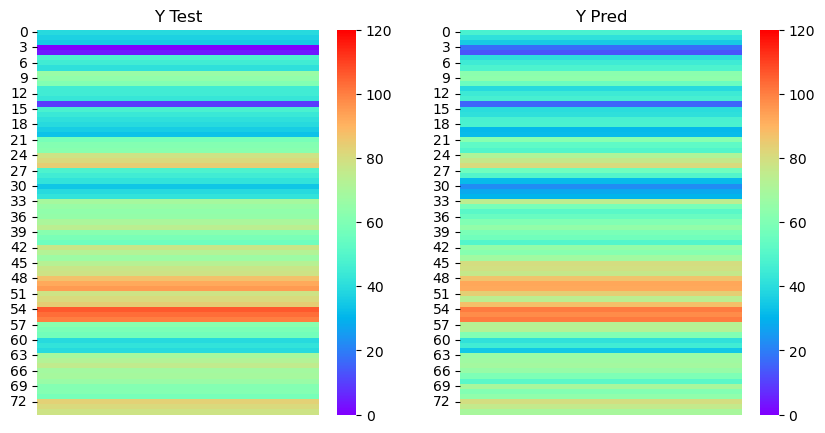

In [70]:
# %% Plot heat plots of true vs predicted 
# Iterate through the subplots
# Plot the data on each subplot
i = 5
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
sns.heatmap(Y_test[i,:].reshape(75,1), vmin=0, vmax=120, cmap = 'rainbow') #  vmin=0, vmax=1
plt.xticks([])
#plt.yticks([])
plt.title('Y Test')

plt.subplot(1,2,2)
sns.heatmap(unnormalized_output_pred[i,:].reshape(75,1), vmin=0, vmax=120, cmap = 'rainbow')
plt.xticks([])
#plt.yticks([])
plt.title('Y Pred')
plt.rcParams['axes.linewidth'] = 8


In [ ]:
import tensorflow as tf

class Network(tf.keras.Model):
    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Layers
        self.conv1 = tf.keras.layers.Conv1D(filters=32, kernel_size=25, input_shape=(None, 12))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv1D(filters=64, kernel_size=15, strides=2)
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=9, strides=2)
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.conv4 = tf.keras.layers.Conv1D(filters=256, kernel_size=3)
        self.bn4 = tf.keras.layers.BatchNormalization()
        
        # Fully Connected Layers
        self.fc1 = tf.keras.layers.Dense(units=128)
        self.bn5 = tf.keras.layers.BatchNormalization()
        self.fc2 = tf.keras.layers.Dense(units=75)
        
        self.relu = tf.keras.layers.ReLU()
        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        # Flatten the tensor for the fully connected layers
        x = tf.keras.layers.Flatten()(x)
        
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        x = self.sigmoid(x)
        
        return x

# Create an instance of the Network model
model = Network()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
#Networ.compile(loss= 'mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_Train, Y_Train, epochs=10, batch_size=32)

# Make predictions on the test data
output_pred = model2.predict(X_test)

# Summary 

The dataset consisted of using 10,000 patients each with an ECG recording of 12 ECG leads and 500 timesteps (12x500x10,000). The primary question was whether a neural network could be constructed to take the 12x500 dataset to predict the 75x1 virtual heart location activation times we were able to predict the activation times of 75 virtual heart location using a 1D convolutional network. The 1D convolutional network took in a 12x500 data matrix and outputed a 75x1 vector. In addition, we used a measure of variance captured, R^2, to measure the model fit of test vs predicted. 